# **Crypto Insights: Market Analytics and Investment Simulation for Top 5 Cryptocurrency**

---

## **Introduction**

The purpose of this project is to investigate the dynamics of the cryptocurrency market and to evaluate the effectiveness of different investment strategies for five leading coins:

| Symbol | Full name |
|--------|-----------|
| BTC    | Bitcoin   |
| ETH    | Ethereum  |
| SOL    | Solana    |
| XRP    | Ripple    |
| ADA    | Cardano   |

The study includes:  
- analysis of historical price series and market capitalization;  
- simulation of investment strategies;  
- comparison of risk and profitability.  

The project allows evaluation of the effectiveness of different investment strategies in the context of cryptocurrency.  
The analysis covers both the level of profitability and the level of risk (volatility, drawdowns), which provides a balanced evaluation of results.  

The results obtained can be useful for *aspiring investors* — as a benchmark for choosing an investment approach, for *traders* — to assess the risk/profitability of different coins, and for *analysts* — as a basis for further research and visualization in business dashboards.  

---

## **Data**

The data was downloaded through the **CoinGecko API** using a custom Python script (`scripts/fetch_api_data.py`) and stored in CSV format for further work.  

### Dataset column description

| Column          | Description                                 |
|-----------------|---------------------------------------------|
| date            | Observation date                            |
| coin_id         | Coin ID in CoinGecko                        |
| symbol          | Exchange ticker (BTC, ETH, SOL, XRP, ADA)   |
| price_usd       | Price of the coin in US dollars             |
| market_cap_usd  | Market capitalization of the coin           |
| volume_usd      | Daily trading volume in US dollars          |

### Terms and definitions

*Volatility* — a measure of fluctuations in cryptocurrency prices for a certain period. This indicator is used to assess the stability of assets and to adjust risk management strategies. High volatility indicates greater investment risk.  

*Diversification* — a strategy where an investor distributes funds among several different cryptocurrencies to reduce risks and increase portfolio stability.  

*Capitalization* — the total market value of all coins of a particular cryptocurrency. It is used to compare the scale of different crypto assets and determine their market share.  

*Liquidity* — characterizes the speed and ease with which an asset can be bought or sold without significantly changing its price. It is important for assessing the practical feasibility of implementing investment strategies and risk management.  

*Portfolio* — a set of investments in different assets, which allows the overall risk and profitability to be evaluated. In this project, the portfolio is used to analyze combined strategies and relationships between different cryptocurrencies.  

---

## **Business Questions**

To ensure the integrity of the analysis, key questions were formulated that logically move from descriptive analytics to the experimental and forecasting part:

1. **Price dynamics:** How did BTC, ETH, SOL, XRP, ADA change during the year?  
2. **Volatility:** Which coin is the riskiest and which is the most stable?  
3. **Drawdowns:** What are the maximum price drops of each coin?  
4. **Correlation:** Do coins move synchronously, and which ones are most related?  
5. **Trading volumes and price dynamics:** Does higher trading volume correspond to stronger price movements?  
6. **Statistical test (t-test):** Is there a significant difference in average returns between high-volume and low-volume days?  
7. **Seasonality:** Are there daily and monthly patterns (days of the week, months) when coins show better or worse dynamics?  
8. **ROI analysis:** What would be the financial result of a one-time $1000 investment in each coin?  
9. **Strategy comparison:** Which strategy is more effective?  
10. **Risk–Return Map:** Is higher profit accompanied by higher risk?  
11. Is it possible to forecast price dynamics 7 days ahead?  
12. **Coin ranking:** Which cryptocurrency is the best in terms of profit-to-risk ratio?  

---


## **A. Environment and Data Preparation**

In [2]:
# Import of libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime, timezone
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import Normalize

from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Downloading data
market_daily = pd.read_csv('data/crypto_market.csv')

In [3]:
# Primary data review

# Time range
market_daily["date"] = pd.to_datetime(market_daily["date"])
print("\nPeriod:", market_daily['date'].min().date(), "→", market_daily['date'].max().date())

# Preview the first rows
print("\n=== Preview ===")
display(market_daily.head())

# DataFrame information
print("\n=== DataFrame info ===")
market_daily.info()

# General statistics
print("\n=== General statistics ===")
display(market_daily.describe())

# Basic price statistics per coin
print("\n=== Basic price statistics by coin ===")
stats_per_coin = market_daily.groupby("symbol")["price_usd"].describe().round(2)
display(stats_per_coin)


Period: 2024-09-14 → 2025-09-13

=== Preview ===


,date,coin_id,symbol,price_usd,market_cap_usd,volume_usd
0,2024-09-14,bitcoin,BTC,60620.627473,1.197832e+12,3.191974e+10
1,2024-09-15,bitcoin,BTC,60003.299401,1.185256e+12,1.580012e+10
2,2024-09-16,bitcoin,BTC,59214.802268,1.169678e+12,1.728960e+10
3,2024-09-17,bitcoin,BTC,58211.123231,1.150499e+12,3.219657e+10
4,2024-09-18,bitcoin,BTC,60317.031979,1.191819e+12,3.419117e+10



=== DataFrame info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1830 non-null   datetime64[ns]
 1   coin_id         1830 non-null   object        
 2   symbol          1830 non-null   object        
 3   price_usd       1830 non-null   float64       
 4   market_cap_usd  1830 non-null   float64       
 5   volume_usd      1830 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 85.9+ KB

=== General statistics ===


,date,price_usd,market_cap_usd,volume_usd
count,1830,1830.000000,1.830000e+03,1.830000e+03
mean,2025-03-15 11:56:03.934426112,19623.842306,4.946950e+11,1.668888e+10
min,2024-09-14 00:00:00,0.323973,1.154625e+10,1.866016e+08
25%,2024-12-14 00:00:00,2.065064,6.425709e+10,2.477420e+09
50%,2025-03-15 12:00:00,169.987787,1.331248e+11,7.072503e+09
75%,2025-06-15 00:00:00,3416.628778,4.113959e+11,2.477249e+10
max,2025-09-13 00:00:00,123560.993636,2.458895e+12,1.904603e+11
std,NaN,38435.466706,7.209692e+11,2.151359e+10



=== Basic price statistics by coin ===


,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
ADA,366.0,0.73,0.21,0.32,0.62,0.74,0.86,1.23
BTC,366.0,95047.53,16295.00,58211.12,84462.29,97202.16,106910.13,123560.99
ETH,366.0,2893.84,791.85,1471.36,2422.16,2658.98,3416.63,4829.23
SOL,366.0,174.98,35.37,105.49,146.82,169.99,199.80,262.56
XRP,366.0,2.13,0.83,0.50,2.07,2.28,2.66,3.56


### Dataset Structure
- The dataset contains **1830 records and 6 columns**, covering five cryptocurrencies over the period **2024-09-14 → 2025-09-13** (366 days).  
- The price range varies significantly: from **$0.32 (ADA) to $123,561 (BTC)**, reflecting the different capitalization and scale of the coins.  
- **Market capitalization** ranges from **~$11 billion to ~$2.46 trillion**, confirming different levels of weight in the cryptocurrency market.  

### Data Quality
- All fields (`date`, `coin_id`, `symbol`, `price_usd`, `market_cap_usd`, `volume_usd`) are **complete, with no missing values**.  
- The number of records is **balanced**: each coin has 366 rows, corresponding to the annual range.  
- The values are **realistic**: for example, the BTC range ($58k–$123k) is consistent with historical trends.  
- **No anomalies**: zero or negative values in prices, capitalization, or volumes are not recorded.  
- Data are **evenly distributed over time**, with no gaps in the time series.  

✅ Overall, the dataset is noted for its **high structure and quality**, which allows it to be used for further analysis and model building.


### Feature Engineering

To make the analysis deeper, new columns were added to the dataset.  
They help capture not only price behavior but also risks and potential investment signals.

1. **return_pct** — daily percentage price change.  
   Shows how many percent today’s price differs from yesterday’s.  
   Used for profitability analysis and volatility calculations.  
   Formula: `(price_t / price_(t-1) - 1) * 100`

2. **rolling_vol_14d** — 14-day rolling volatility.  
   Allows evaluation of how stable or risky a coin is during a certain period.  
   Calculated as the standard deviation of daily changes over 14 days.

3. **drawdown_pct** — shows the largest decrease in the value of an asset or portfolio from a local maximum to the next minimum.  
   Important for assessing potential losses and strategy resilience during market crises.  
   Formula: `(price - max_to_date) / max_to_date * 100`

4. **weekday / month** — day of the week and month.  
   Used to detect seasonality and recurring patterns in price behavior.

5. **is_dip_3d** — “dip” indicator (price drops ≥5% within 3 days).  
   Determines moments when a significant decline occurred.  
   Used in the “buy the dip” strategy.  
   `is_dip_3d`: equals `1` if the drop is ≥5% within 3 days, otherwise `0`.


In [4]:
# Add columns to Market_Daily
market_daily["return_pct"] = market_daily.groupby("coin_id")["price_usd"].pct_change() * 100
market_daily["rolling_vol_14d"] = market_daily.groupby("coin_id")["return_pct"].rolling(14).std().reset_index(0, drop=True)
market_daily["drawdown_pct"] = market_daily.groupby("coin_id")["price_usd"].transform(lambda x: (x - x.cummax())/x.cummax()*100)
market_daily["weekday"] = market_daily["date"].dt.day_name()
market_daily["month"] = market_daily["date"].dt.month
market_daily["return_3d"] = market_daily.groupby("coin_id")["price_usd"].pct_change(3) * 100
market_daily["is_dip_3d"] = (market_daily["return_3d"] <= -5).astype(int)

market_daily.head()

,date,coin_id,symbol,price_usd,market_cap_usd,volume_usd,return_pct,rolling_vol_14d,drawdown_pct,weekday,month,return_3d,is_dip_3d
0,2024-09-14,bitcoin,BTC,60620.627473,1.197832e+12,3.191974e+10,NaN,NaN,0.000000,Saturday,9,NaN,0
1,2024-09-15,bitcoin,BTC,60003.299401,1.185256e+12,1.580012e+10,-1.018347,NaN,-1.018347,Sunday,9,NaN,0
2,2024-09-16,bitcoin,BTC,59214.802268,1.169678e+12,1.728960e+10,-1.314090,NaN,-2.319054,Monday,9,NaN,0
3,2024-09-17,bitcoin,BTC,58211.123231,1.150499e+12,3.219657e+10,-1.694980,NaN,-3.974727,Tuesday,9,-3.974727,0
4,2024-09-18,bitcoin,BTC,60317.031979,1.191819e+12,3.419117e+10,3.617708,NaN,-0.500812,Wednesday,9,0.522859,0


# **B. Basic Review**

### 1. Dynamics of Coin Prices per Year
**Purpose:** Visualize price changes of each coin over time.  
**Expected result:** Identify general trends (growth/decline) and periods of increased activity.


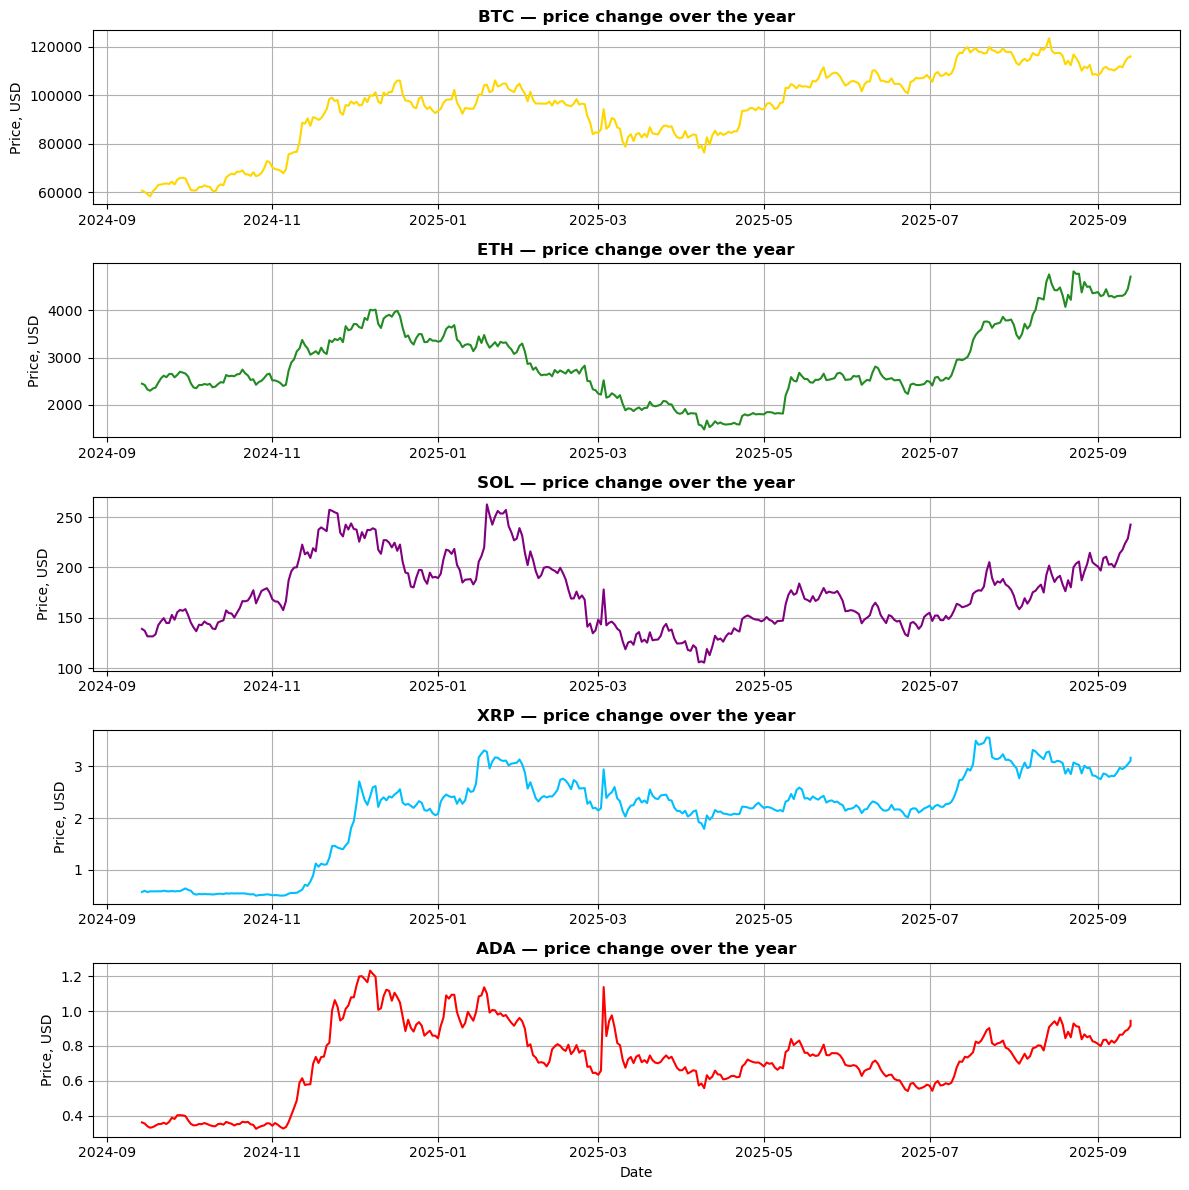

In [5]:
# Fix colors for each coin
coin_colors = {
    "BTC": "#FFD700",   # gold
    "ETH": "#228B22",   # green
    "SOL": "#800080",   # purple
    "XRP": "#00BFFF",   # blue
    "ADA": "#FF0000"    # red
}

# Unique coin tickers
coins = market_daily['symbol'].unique()

# Area for graphs
fig, axes = plt.subplots(5, 1, figsize=(12, 12))
for i, coin in enumerate(coins):
    sub = market_daily[market_daily['symbol'] == coin]
    axes[i].plot(
        sub['date'], 
        sub['price_usd'], 
        label=coin, 
        color=coin_colors[coin]
    )
    axes[i].set_title(f"{coin} — price change over the year", fontweight="bold")
    axes[i].set_ylabel("Price, USD")
    axes[i].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


**Conclusions:**  
- **BTC** shows a stable uptrend and is the most reliable asset for long-term investment.  
- **ETH** and **XRP** have strong growth potential but are characterized by pronounced corrections.  
- **SOL** and **ADA** are more volatile: suitable for active trading but riskier for passive holding.

### 2. Volatility
**Purpose:** Compare the riskiness of coins based on their daily percentage changes (`return_pct`) and 14-day rolling volatility (`rolling_vol_14d`).  
**Expected result:** Determine which coins demonstrate the largest fluctuations (most risky) and which are characterized by more stable dynamics.

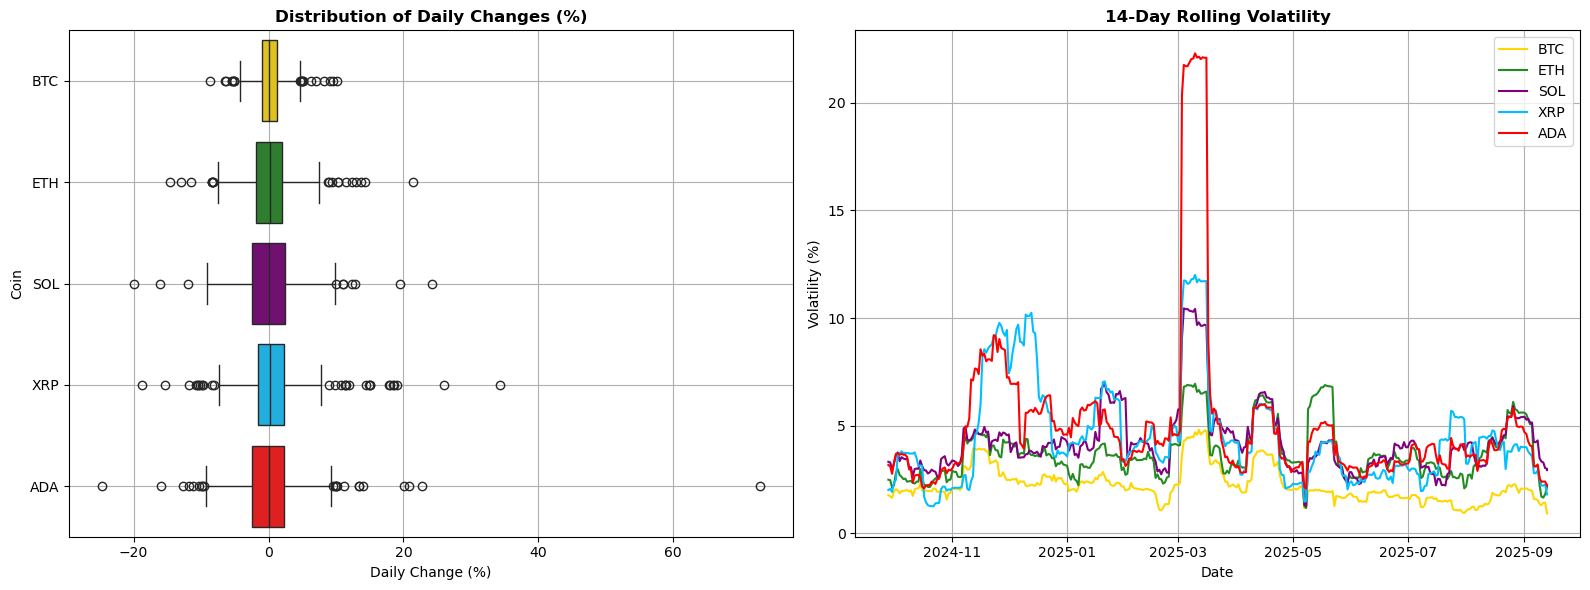

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Boxplot for daily changes
sns.boxplot(
    data=market_daily,
    x="return_pct",
    y="symbol",
    hue="symbol",
    palette=coin_colors,
    vert=False,
    ax=axes[0]
)
axes[0].set_title("Distribution of Daily Changes (%)", fontweight="bold")
axes[0].set_xlabel("Daily Change (%)")
axes[0].set_ylabel("Coin")
axes[0].grid()

# 2. Line chart of 14-day rolling volatility
for i, coin in enumerate(coins):
    sub = market_daily[market_daily['symbol'] == coin]
    axes[1].plot(
        sub["date"], 
        sub["rolling_vol_14d"], 
        label=coin, 
        color=coin_colors[coin]
    )
axes[1].set_title("14-Day Rolling Volatility", fontweight="bold")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Volatility (%)")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

**Conclusions:**  

- **BTC and ETH** — relatively stable coins. Daily changes are usually within ±5%, and volatility ranges from 5–7%. This makes them more predictable for long-term investment.  
- **SOL and ADA** — the most volatile. Frequent large deviations and sharp jumps (>20%) indicate the high risk and speculative nature of these assets.  
- **XRP** — takes an intermediate position: mostly stable, but periodically demonstrates sharp fluctuations.  


### 3. Drawdowns
**Purpose:** Assess the maximum declines from local peaks for each cryptocurrency (`drawdown_pct`).  
**Expected result:** Provide an understanding of the worst-case scenarios of price drops that an investor may face.


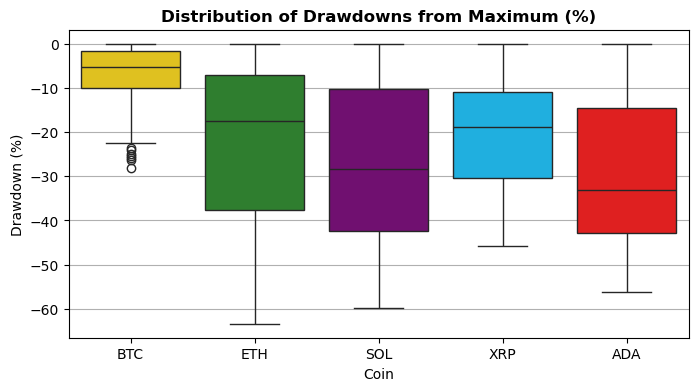

In [7]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=market_daily,
    x="symbol", 
    y="drawdown_pct",
    hue="symbol",
    palette=coin_colors
)

plt.title("Distribution of Drawdowns from Maximum (%)", fontweight="bold")
plt.xlabel("Coin")
plt.ylabel("Drawdown (%)")
plt.grid(axis='y')

plt.show()

**Conclusions:**

- **BTC** — the smallest drawdowns: mostly within −10…−20%, rarely below −30%. The most stable asset.  
- **ETH** — significantly deeper drawdowns: often more than −40%, with some cases reaching −60%.  
- **SOL, ADA** — the riskiest: median around −30%, with maximum drops exceeding −50%.  
- **XRP** — occupies an intermediate position: typical drawdowns of −20…−30%, occasionally down to −40%.  


# **C. Relationships and Market Indicators**

### 4. Correlation Between Coins
**Purpose:** Determine how synchronously the prices of different cryptocurrencies move and whether there are strong or weak relationships between them.


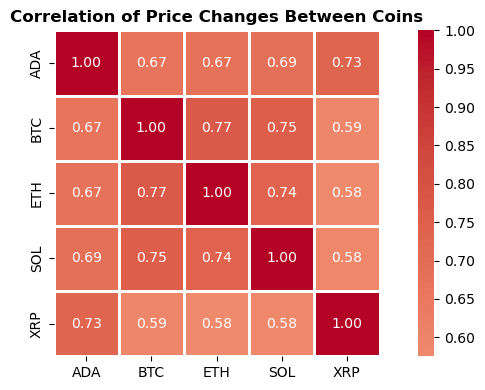

In [8]:
# Remove duplicates
market_daily_no_dup = market_daily.drop_duplicates(subset=['date', 'symbol'])

# Convert into wide format: Date × coins
returns = market_daily_no_dup.pivot(index="date", columns="symbol", values="return_pct")

# Calculate correlation between coins
corr_matrix = returns.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    center=0, 
    cmap="coolwarm", 
    square=True,
    linewidths=1
)

plt.title("Correlation of Price Changes Between Coins", fontweight='bold')
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()

plt.show()

**Conclusions:**

- **BTC, ETH, and SOL** demonstrate the highest mutual correlation (0.74–0.77).  
  This means their prices change almost synchronously, and the rise or fall of one coin is often reflected in the others.  

- **ADA** shows a high but slightly lower level of correlation (0.67–0.73).  
  It follows the overall market trend but with less intensity, which makes it more flexible during periods of sharp fluctuations.  

- **XRP** remains in the medium-to-high correlation range (0.58–0.73).  
  It generally moves with the market but can sometimes deviate from the overall trend.  

### 5. Relationship Between Trading Volumes and Price Changes
**Purpose:** Investigate whether there is a link between daily trading volumes and the magnitude of percentage price changes for different coins.  
This will help test the hypothesis that periods of high trading volumes are accompanied by sharper fluctuations.

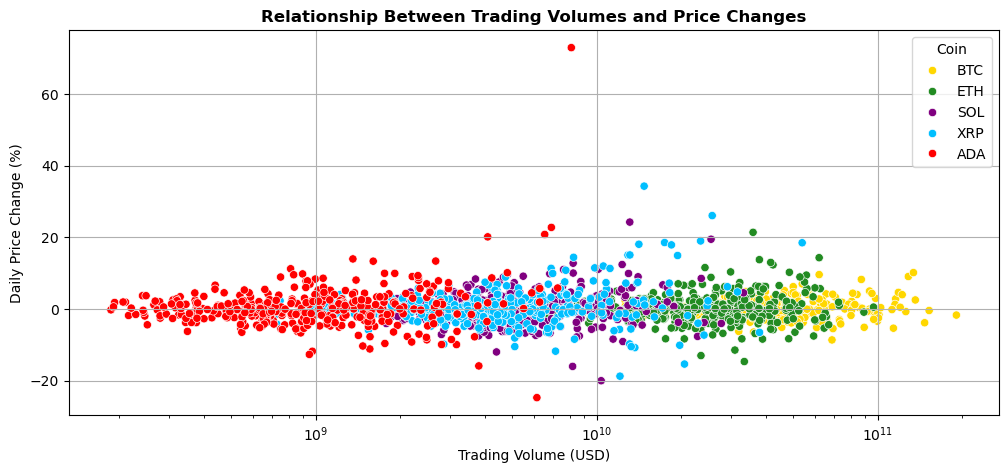

In [9]:
scatter_data = market_daily[['symbol', 'volume_usd', 'return_pct']].dropna()

plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=scatter_data,
    x='volume_usd', 
    y='return_pct', 
    hue='symbol', 
    palette=coin_colors
)

plt.xscale('log')  # logarithmic scale for volumes
plt.title("Relationship Between Trading Volumes and Price Changes", fontweight='bold')
plt.xlabel("Trading Volume (USD)")
plt.ylabel("Daily Price Change (%)")
plt.legend(title="Coin")

plt.grid()
plt.show()

### 6. T-test
**Purpose:** Verify whether the hypothesis *“Large volumes → Large movements”* is confirmed using a statistical test.  

**Hypotheses:**  
- **H₀:** The average daily return on days with high and low volumes **does not differ**.  
- **H₁:** The average daily return on days with high and low volumes **differs**.  

**Expected result:**  
- If *p-value < 0.05* → reject H₀, i.e., the difference is statistically significant.  
- If *p-value ≥ 0.05* → do not reject H₀, i.e., there is no significant difference.  

**Explanation:**  
This test complements the scatterplot *“Volume ↔ Price Changes”*: if the chart shows strong deviations at high volumes, the t-test formally checks whether this is random noise or a systemic pattern.  
> The study uses a **t-test** because we work with sample data and do not know the population standard deviation. For large samples, the t-test almost coincides with the z-test but is more versatile and reliable.

In [10]:
results = []

# For each coin separately
for coin in market_daily['symbol'].unique():
    sub = market_daily[market_daily['symbol'] == coin].dropna(subset=['volume_usd', 'return_pct'])
    
    # Threshold: 70th and 30th quantile volumes
    low = sub[sub['volume_usd'] <= sub['volume_usd'].quantile(0.3)]['return_pct']
    high = sub[sub['volume_usd'] >= sub['volume_usd'].quantile(0.7)]['return_pct']
    
    # T-test
    t_stat, p_val = ttest_ind(high, low, equal_var=False)
    
    results.append({
        "Coin": coin,
        "Mean (Low)": round(low.mean(), 3),
        "Mean (High)": round(high.mean(), 3),
        "t-statistic": round(t_stat, 3),
        "p-value": round(p_val, 4),
        "Interpretation": "✅ Significant difference" if p_val < 0.05 else "Not significant"
    })

# Table of results
t_test_results = pd.DataFrame(results)
t_test_results


,Coin,Mean (Low),Mean (High),t-statistic,p-value,Interpretation
0,BTC,-0.060,0.607,2.043,0.0431,✅ Significant difference
1,ETH,0.090,0.690,1.096,0.2750,Not significant
2,SOL,0.055,1.000,1.482,0.1405,Not significant
3,XRP,0.039,2.093,2.574,0.0113,✅ Significant difference
4,ADA,-0.169,1.293,1.509,0.1338,Not significant


**Conclusions:**

The analysis combined two approaches — **visualization(scatterplot)** and **statistics (t-test)** — which allows drawing more comprehensive conclusions:

- **BTC and XRP** confirmed the relationship between liquidity and price movements.  
  The *scatterplot* clearly shows that at high volumes, the points for these coins “stretch” upward, demonstrating price jumps.  
  The *t-test* confirmed this statistically: on days with high volumes, the average return is significantly higher.  
  This means that for BTC and XRP, **increasing volume can be an early signal of future price movements**.  

- **ETH and SOL** showed a less pronounced picture.  
  The *scatterplot* indicates some widening of distribution at higher volumes but without a clear structure.  
  The *t-test* did not yield a statistically significant difference.  
  This may indicate that ETH and SOL movements are more often driven by other factors: news, macro trends, or technical updates.  

- **ADA** has a specific profile.  
  On the *scatterplot*, isolated bursts with high volumes and strong price deviations can be seen.  
  However, the *t-test* showed that the average difference between low- and high-volume days was not statistically significant.  
  This may indicate more “chaotic” dynamics where **individual events have a strong but non-systemic impact**.  


### 7. Seasonality and Daily Patterns
**Purpose:** Check whether there are patterns in price dynamics depending on the day of the week or month.  

**Expected result:**  
- If patterns exist — certain days or months will show consistently positive or negative changes.  
- If no patterns exist — the average values will be distributed fairly evenly.  

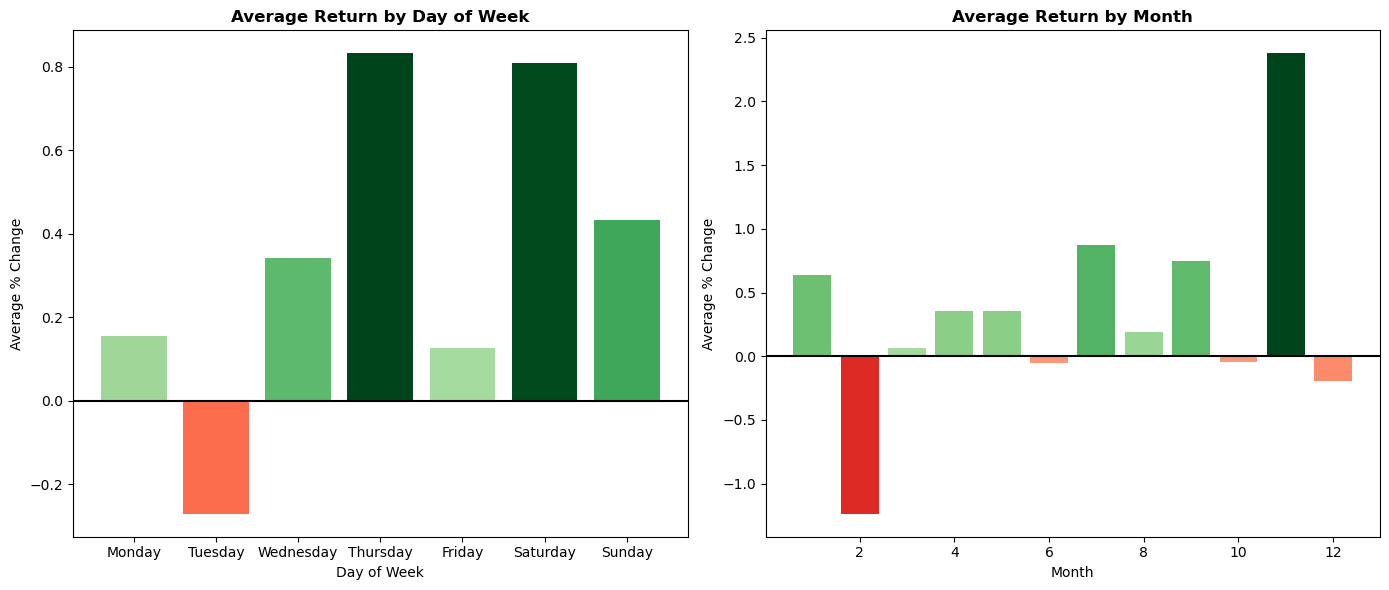

In [11]:
# Average return by day and month
avg_by_weekday = market_daily.groupby("weekday")["return_pct"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
avg_by_month = market_daily.groupby("month")["return_pct"].mean().reindex(range(1, 13))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Days of the week
values_day = avg_by_weekday.values
norm_day = Normalize(vmin=min(values_day), vmax=max(values_day))
colors_day = [cm.Greens(norm_day(v)) if v > 0 else cm.Reds(norm_day(abs(v))) for v in values_day]

axes[0].bar(
    avg_by_weekday.index, 
    avg_by_weekday.values, 
    color=colors_day
)
axes[0].axhline(y=0, color='black', linestyle='-')
axes[0].set_title("Average Return by Day of Week", fontweight='bold')
axes[0].set_xlabel("Day of Week")
axes[0].set_ylabel("Average % Change")

# Months
values_month = avg_by_month.values
norm_month = Normalize(vmin=min(values_month), vmax=max(values_month))
colors_month = [cm.Greens(norm_month(v)) if v > 0 else cm.Reds(norm_month(abs(v))) for v in values_month]

axes[1].bar(
    avg_by_month.index, 
    avg_by_month.values, 
    color=colors_month
)
axes[1].axhline(y=0, color='black', linestyle='-')
axes[1].set_title("Average Return by Month", fontweight='bold')
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Average % Change")

plt.tight_layout()
plt.show()

**Conclusions:**

- **Days of the week.** Within the sample, there are differences in average returns between days.  
  The lowest result is recorded on *Tuesday*, while *Thursday* and *Saturday* show the highest average values.  
  This may indicate recurring intra-week patterns in cryptocurrency dynamics.  

- **Months.** Certain calendar periods also stand out.  
  *February* shows a negative average return, whereas *November* is distinguished by positive yields.

# **D. Investment Strategies**

To understand how different investment approaches affect the effectiveness of cryptocurrency investments, a separate simulation table of strategies was created.  
It contains the final profitability value for each coin and each strategy, allowing estimation of what works better: one-time investment, gradual contributions, or buying on dips.  

### Structure of the Simulation Table

| Column              | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| **coin**            | Cryptocurrency ID (BTC, ETH, SOL, XRP, ADA).                                |
| **strategy**        | The investment strategy used (BUY & HOLD, DCA, BUY-ON-DIP).                 |
| **amount_usd**      | Initial investment in US dollars (fixed at $1000).                          |
| **final_value_usd** | Final value of the investment after simulation.                             |
| **profit_usd**      | Absolute profit in dollars (`final_value_usd - amount_usd`).                 |
| **roi_pct**         | Percentage profitability from initial investment.                           |

Thus, this table is a practical tool for testing the hypothesis:  
*Is it justified for an investor to use more complex approaches, or does a simple "buy and hold" yield the same result?*


In [12]:
# Basic functions for investment strategies

def one_time_invest(df, amount):
    """
    Simulation of a one-time investment (Buy & Hold).
    Buy at the beginning of the period and calculate the final investment value at the end of the period.
    """
    start_price = df.iloc[0]["price_usd"]
    end_price = df.iloc[-1]["price_usd"]
    final_value = amount * (end_price / start_price)
    return final_value

def dca_invest(df, amount, periods=12):
    """
    Simulation of the Dollar-Cost Averaging (DCA) strategy.
    Divide the investment into equal parts and purchase the coin monthly at the current price.
    """
    monthly_amount = amount / periods
    df_monthly = df.set_index("date").resample("ME").first().reset_index()
    coins_bought = (monthly_amount / df_monthly["price_usd"]).sum()
    final_value = coins_bought * df.iloc[-1]["price_usd"]
    return final_value

def buy_on_dip(df, amount, threshold=-5):
    """
    Simulation of the "Buy on Dip" strategy.
    Buy only once — during the first significant drop (3 consecutive days with decline ≤ threshold).
    """
    coins_bought = 0
    cash = amount
    num_trades = 0

    for i, row in df.iterrows():
        if row["return_3d"] <= threshold and cash > 0:
            coins_bought = cash / row["price_usd"]
            cash = 0
            num_trades = 1   
            break            

    final_value = coins_bought * df.iloc[-1]["price_usd"] + cash
    return final_value, num_trades

In [13]:
# Initial parameters
initial_amount = 1000   # $1000
coins = market_daily['symbol'].unique()

# Simulation results will be kept on the list
sim_results = []
    
# Starting simulations for all coins
for coin in coins:
    df_coin = market_daily[market_daily["symbol"] == coin].reset_index(drop=True)
    
# # Buy & Hold
    final_value = one_time_invest(df_coin, initial_amount)
    roi = (final_value - initial_amount) / initial_amount * 100
    sim_results.append({
        "symbol": coin,
        "strategy": "Buy & Hold",
        "amount_usd": initial_amount,
        "final_value_usd": round(final_value, 2),
        "profit_usd": round(final_value - initial_amount, 2),
        "roi_pct": round(roi, 2)
    })
    
# # DCA
    final_value = dca_invest(df_coin, initial_amount, periods=12)
    roi = (final_value - initial_amount) / initial_amount * 100
    sim_results.append({
        "symbol": coin,
        "strategy": "DCA",
        "amount_usd": initial_amount,
        "final_value_usd": round(final_value, 2),
        "profit_usd": round(final_value - initial_amount, 2),
        "roi_pct": round(roi, 2)
    })
    
# # Buy On Dip
    final_value, _ = buy_on_dip(df_coin, initial_amount, threshold=-5)
    roi = (final_value - initial_amount) / initial_amount * 100
    sim_results.append({
        "symbol": coin,
        "strategy": "Buy on Dip",
        "amount_usd": initial_amount,
        "final_value_usd": round(final_value, 2),
        "profit_usd": round(final_value - initial_amount, 2),
        "roi_pct": round(roi, 2)
    })

# Dataframe
sim_results = pd.DataFrame(sim_results)

### 8. ROI Analysis

**Purpose:** Assess the profitability of coins in the "Buy & Hold" scenario.  
This allows determining which assets showed the highest value growth and how the efficiency of different cryptocurrencies varied under the same investment conditions.  

In [14]:
buy_hold = sim_results[sim_results["strategy"] == "Buy & Hold"].sort_values("roi_pct", ascending=False).reset_index(drop=True)
buy_hold

,symbol,strategy,amount_usd,final_value_usd,profit_usd,roi_pct
0,XRP,Buy & Hold,1000,5523.84,4523.84,452.38
1,ADA,Buy & Hold,1000,2617.19,1617.19,161.72
2,ETH,Buy & Hold,1000,1929.21,929.21,92.92
3,BTC,Buy & Hold,1000,1914.13,914.13,91.41
4,SOL,Buy & Hold,1000,1745.04,745.04,74.50


**Conclusions:**

- **XRP and ADA** demonstrated the highest returns.  
- **BTC and ETH** confirmed their role as core assets — stable but with moderate growth and without sharp jumps.  
- **SOL** showed the most modest increase but remained in the positive zone.  

### 9. Comparison of Investment Strategies

**Purpose:** Compare key investment approaches to determine whether it is more profitable to invest all at once, gradually, or by buying on dips.  
This helps evaluate how different strategies affect investor outcomes in a volatile crypto market.  

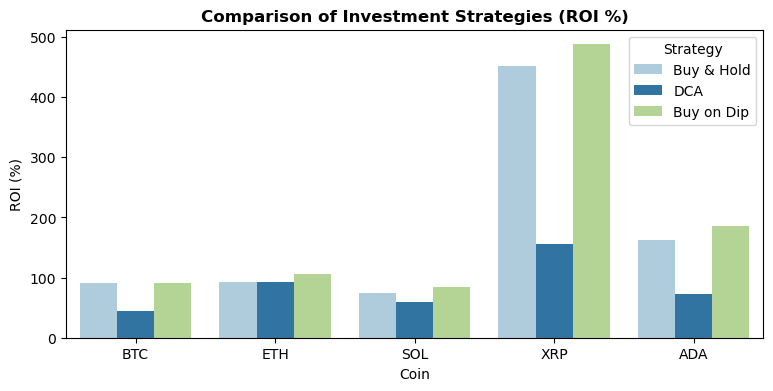

In [15]:
plot_data = sim_results[["symbol", "strategy", "roi_pct"]]

plt.figure(figsize=(9, 4))
sns.barplot(
    data=plot_data,
    x="symbol",
    y="roi_pct",
    hue="strategy",
    palette="Paired"
)

plt.title("Comparison of Investment Strategies (ROI %)", fontweight="bold")
plt.xlabel("Coin")
plt.ylabel("ROI (%)")
plt.legend(title="Strategy")

plt.show()

**Conclusions:**

- **Buy & Hold** proved to be the most effective in most cases: the simple “buy and hold” strategy delivers consistently high results.  
- **DCA** turned out to be the least profitable: gradual purchases reduce risk but at the same time “smooth out” potential profit.  
- **Buy on Dip** can outperform Buy & Hold in some scenarios, but its success strongly depends on the timing of entry.  

### 10. Risk–Return Map

**Purpose:** Build a "risk–return" map where coins and strategies are displayed.  
This helps assess whether the expected logic *“higher return = higher risk”* holds true in the sample.  


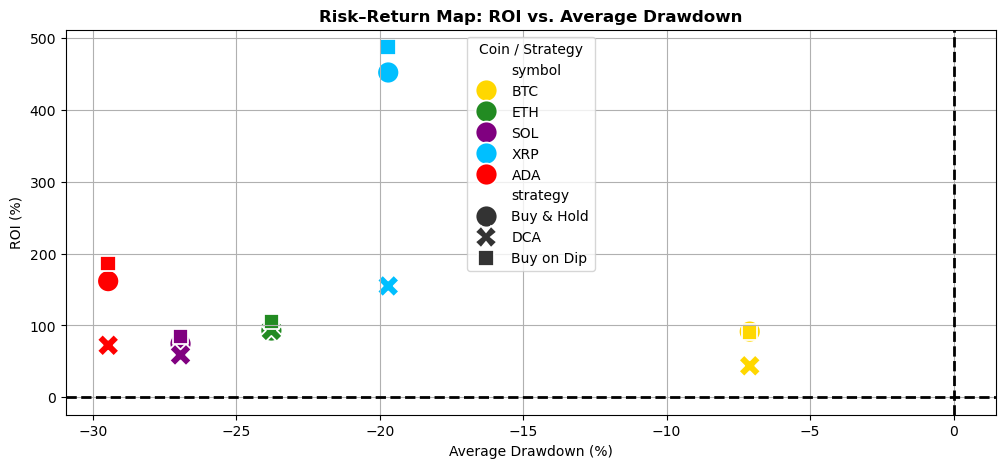

In [16]:
# Average drawdown for each coin
avg_drawdowns = market_daily.groupby("symbol")["drawdown_pct"].mean()

# Merge with the simulation table
risk_return = sim_results.merge(avg_drawdowns, on="symbol", how="left")

# Construct Risk–Return Map
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=risk_return,
    x="drawdown_pct", 
    y="roi_pct", 
    hue="symbol",
    palette=coin_colors,
    style="strategy", 
    s=250
)

plt.axhline(0, color="black", linestyle="--", linewidth=2)
plt.axvline(0, color="black", linestyle="--", linewidth=2)
plt.title("Risk–Return Map: ROI vs. Average Drawdown", fontweight="bold")
plt.xlabel("Average Drawdown (%)")
plt.ylabel("ROI (%)")
plt.legend(title="Coin / Strategy")
plt.grid()

plt.show()

**Conclusions:**

- **XRP** — the undisputed leader: the *Buy on Dip* strategy gave almost +490% with an average drawdown of ~–20%. Even *Buy & Hold* showed more than +450%. This demonstrates a strong upward trend and the benefits of aggressive strategies.  
- **ADA** — second place: ROI of ~160–180%, but with the highest drawdowns (≈ –30%). The coin is potentially profitable but risky.  
- **BTC and ETH** — more stable assets. ROI of +90–105% with moderate drawdowns (–7% to –25%). DCA (~90%) worked for ETH, while for BTC this strategy was the least profitable.  
- **SOL** — the weakest asset: lower ROI combined with significant drawdowns (≈ –30%), which makes it the least attractive to investors.

# **E. ML Modeling**

### 11. Bitcoin Price Forecast
**Purpose:** Check whether even a simple *Linear Regression* model can capture short-term trends in cryptocurrency price time series.  

For example, **Bitcoin (BTC)** is chosen because it is the most liquid and stable asset among cryptocurrencies and often serves as a "barometer" of the market.  
The horizon of **7 days** is selected as a typical interval for short-term traders.  

**Expected result:**  
- Obtain basic accuracy metrics (MAE, RMSE, R²).  
- Build a chart of actual vs. predicted prices.  
- Further evaluate errors (histogram, scatterplot, top 5 deviations).  

=== Time Series Cross-Validation ===
MAE = 1644.87
RMSE = 2226.69
R² = 0.770


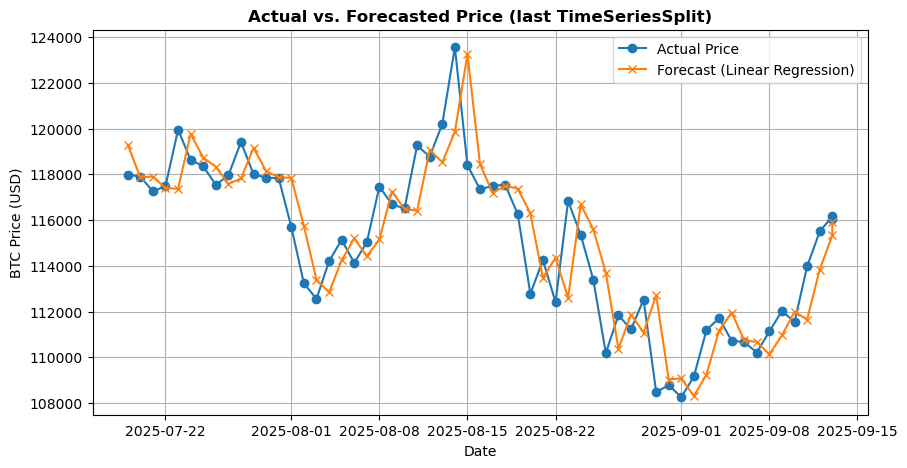

In [17]:
# 1. Filter for BTC
df_btc = market_daily[market_daily["symbol"] == "BTC"].copy().reset_index(drop=True)

# Lags (7 days ago)
for lag in range(1, 8):
    df_btc[f"lag_{lag}"] = df_btc["price_usd"].shift(lag)

# Remove missing values
df_btc = df_btc.dropna().reset_index(drop=True)

# Features and target
X = df_btc[[f"lag_{i}" for i in range(1, 8)]]
y = df_btc["price_usd"]

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, rmse_scores, r2_scores = [], [], []
last_split = None

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

    # Save last split for visualization
    last_split = (y_test.index, y_test, y_pred)

print("=== Time Series Cross-Validation ===")
print(f"MAE = {np.mean(mae_scores):.2f}")
print(f"RMSE = {np.mean(rmse_scores):.2f}")
print(f"R² = {np.mean(r2_scores):.3f}")

# Visualization
test_idx, y_test, y_pred = last_split

plt.figure(figsize=(10, 5))
plt.plot(df_btc["date"].iloc[test_idx], y_test, label="Actual Price", marker="o")
plt.plot(df_btc["date"].iloc[test_idx], y_pred, label="Forecast (Linear Regression)", marker="x")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.title("Actual vs. Forecasted Price (last TimeSeriesSplit)", fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


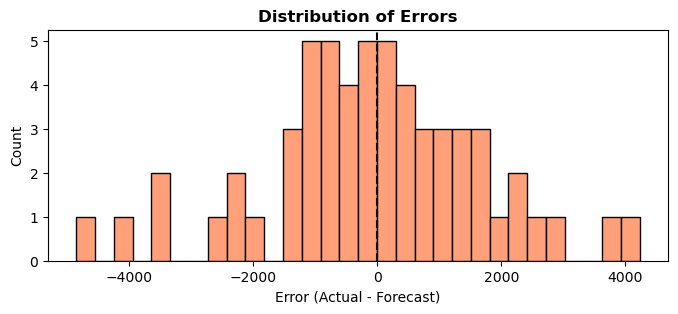

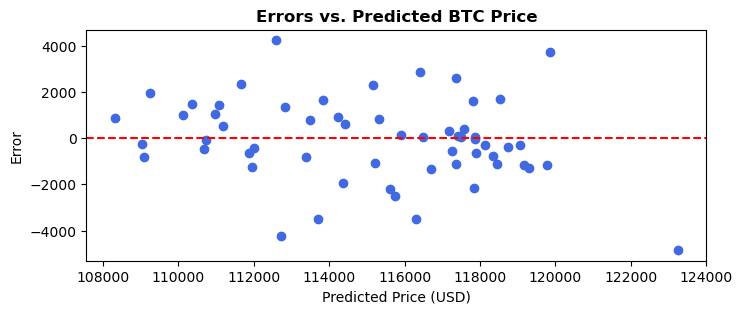


=== Top 5 Largest Forecasting Errors: ===


,Actual Price,Predicted Price,Error
321,118405.60,123256.62,4851.03
336,108480.31,112716.44,4236.14
329,116834.25,112600.72,4233.53
320,123560.99,119851.26,3709.73
326,112778.34,116297.89,3519.54


In [18]:
# Analysis of Errors on the Last Split
residuals = y_test - y_pred

# Histogram of errors
plt.figure(figsize=(8, 3))
plt.hist(
    residuals, 
    bins=30, 
    color="lightsalmon",
    edgecolor="black",
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribution of Errors", fontweight="bold")
plt.xlabel("Error (Actual - Forecast)")
plt.ylabel("Count")
plt.show()

# Scatter plot: Errors vs. Predicted values
plt.figure(figsize=(8, 3))
plt.scatter(
    y_pred, 
    residuals,  
    color="royalblue", 
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Errors vs. Predicted BTC Price", fontweight="bold")
plt.xlabel("Predicted Price (USD)")
plt.ylabel("Error")
plt.show()

# Create dataframe with the largest errors
errors_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred,
    "Error": np.abs(residuals)
})

# Top 5 biggest errors
top_errors = errors_df.nlargest(5, 'Error')
print("\n=== Top 5 Largest Forecasting Errors: ===")
display(top_errors.round(2))

**Conclusions**

The Linear Regression model reproduced the overall BTC price dynamics quite well: the coefficient of determination R² ≈ 0.77 shows that the model explains most fluctuations.  
The average error (MAE ≈ 1.6–1.7k USD) is relatively small for such a volatile asset, although accuracy remains limited.  

Error analysis showed that:  
- **Most forecasts** deviate within ±2000 USD, meaning the model consistently captures the trend.  
- **The largest errors** occur during sharp spikes or drops, where linear regression “smooths” the market and lags behind actual values.  
- **The distribution of residuals** is symmetrical, with no systematic bias in one direction, confirming the neutrality of the model.  

**Practical conclusion:** A basic ML model can be useful for evaluating the general BTC trend over a short-term horizon (7 days), but more accurate forecasts during sharp market movements require more complex algorithms.  

# **F. Results**

### 12. Rating of Coins by Profit-to-Risk Ratio

**Purpose:** Evaluate coins not only by absolute profits (ROI) but also by volatility.  
This will help determine which assets deliver the highest return per unit of risk.  


=== Sharpe Ratio by Coins ===


,symbol,avg_return,volatility,roi_pct,sharpe_ratio
0,ADA,0.431,6.180,161.72,0.070
1,BTC,0.205,2.314,91.41,0.088
2,ETH,0.255,3.905,92.92,0.065
3,SOL,0.250,4.440,74.50,0.056
4,XRP,0.596,5.155,452.38,0.116


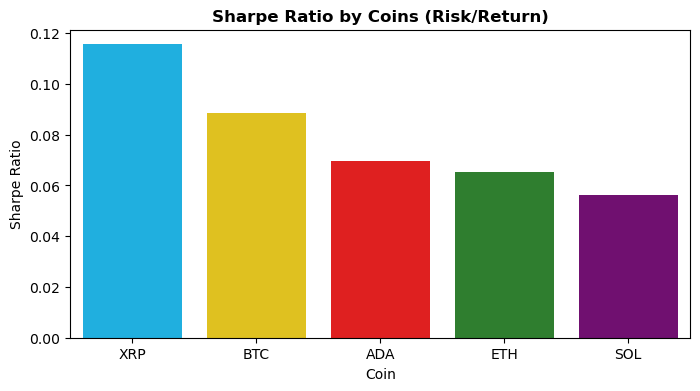

In [19]:
# Average return and volatility
sharpe_df = (
    market_daily.groupby("symbol")["return_pct"]
    .agg(avg_return="mean", volatility="std")
    .reset_index()
)

# ROI from the simulation table
sharpe_df = sharpe_df.merge(
    sim_results[["symbol", "roi_pct"]].drop_duplicates("symbol"),
    on="symbol",
    how="left"
)

# Sharpe Ratio
sharpe_df["sharpe_ratio"] = sharpe_df["avg_return"] / sharpe_df["volatility"]

print("\n=== Sharpe Ratio by Coins ===")
display(sharpe_df[["symbol", "avg_return", "volatility", "roi_pct", "sharpe_ratio"]].round(3))

# --- Visualization ---
plt.figure(figsize=(8, 4))
sns.barplot(
    data=sharpe_df.sort_values("sharpe_ratio", ascending=False),
    x="symbol",
    y="sharpe_ratio",
    hue="symbol",
    palette=coin_colors
)
plt.title("Sharpe Ratio by Coins (Risk/Return)", fontweight="bold")
plt.xlabel("Coin")
plt.ylabel("Sharpe Ratio")

plt.show()

**Conclusions:**  
The Sharpe Ratio shows how effectively each coin compensates for risk with its returns:

- **XRP** — has the highest Sharpe Ratio (≈ **0.116**), providing the best risk–return balance. This makes it the most effective asset in the sample.  
- **BTC** — takes second place (≈ **0.088**). Bitcoin remains a relatively stable asset with moderate risk and returns.  
- **ADA** — shows an average result (≈ **0.070**), indicating a decent balance of risk and profitability.  
- **ETH** and **SOL** — the lowest values (≈ **0.065–0.053**). They demonstrate higher volatility with similar average returns, which makes them less effective in terms of risk management.  

---

# 📌 **Final Conclusions**

This project demonstrated a comprehensive approach to cryptocurrency analysis, combining descriptive statistics, visualization, investment strategy simulations, statistical tests, and ML modeling.

---

### 1. 📊 Basic Review
- **Prices:** All coins increased over the year, but the pace varied.  
- **Volatility:** XRP and ADA are the riskiest; BTC and ETH are more stable.  
- **Drawdowns:** The largest drops were in ADA, but all coins experienced significant declines.  

---

### 2. 🔗 Relationships and Market Factors
- **Correlations:** Core cryptocurrencies (BTC, ETH, SOL) move in coordination and form the market backbone, whereas XRP is not fully aligned and can be a potentially useful asset for **portfolio diversification**, since it may move differently than most.  
- **Trading volumes:** Scatterplots and t-tests showed that for BTC and XRP, high volumes significantly increase returns; for ETH, SOL, and ADA, the effect was not confirmed.  
- **Seasonality:** Patterns were found across days and months. However, since the analysis was based on only one year of data, the detected patterns may partly reflect **one-off events or external market factors** rather than stable trends.  

---

### 3. 💰 Investment Strategies
- **Buy & Hold:** All coins were profitable; leaders — XRP (+450–480%) and ADA (+160–180%).  
- **DCA:** Reduced risks but significantly limited profits (especially for BTC).  
- **Buy on Dip:** Worked best for XRP and ADA; sometimes outperformed Buy & Hold but depended heavily on the frequency of dips.  
- **Risk–Return Map:** XRP and ADA — high profits with larger drawdowns; BTC and ETH — balanced; SOL — the weakest performer.  

---

### 4. ⚖️ Risk/Return (Sharpe Ratio)
- **XRP** — best profit-to-risk ratio.  
- **BTC** — optimal "balance": lower ROI but high reliability.  
- **ETH, SOL, ADA** — less efficient: higher risk with weaker returns.  

---

## ✅ General Summary
- **For investors:** The most attractive assets are XRP (as a profit driver) and BTC (as a stabilizer).  
- **For traders:** Buy & Hold and Buy on Dip are more beneficial than DCA, though the risk of drawdowns remains.  
- **For business cases:** The combination of descriptive statistics, investment strategies, t-tests, and ML modeling proves that a comprehensive approach helps better understand the crypto market and make informed decisions.  

In [20]:
# Save results in CSV

# Market data (full dataset by day)
market_daily.to_csv("data/market_daily.csv", index=False)

# Simulation results
sim_results.to_csv("data/sim_results.csv", index=False)

print("Data saved to the 'data/' folder: market_daily.csv and sim_results.csv")

Data saved to the 'data/' folder: market_daily.csv and sim_results.csv
